In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud 
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
%matplotlib inline

In [2]:
train = pd.read_csv("../inputs/train.csv")
vali = pd.read_csv("../inputs/vali.csv")
test = pd.read_csv("../inputs/testa.csv")

In [3]:
train.shape, vali.shape, test.shape

((105000, 22), (15000, 22), (15000, 22))

In [4]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("Check for missing values in Vali dataset")
null_check=vali.isnull().sum()
print(null_check)


Check for missing values in Train dataset
id                                          0
content                                     0
location_traffic_convenience                0
location_distance_from_business_district    0
location_easy_to_find                       0
service_wait_time                           0
service_waiters_attitude                    0
service_parking_convenience                 0
service_serving_speed                       0
price_level                                 0
price_cost_effective                        0
price_discount                              0
environment_decoration                      0
environment_noise                           0
environment_space                           0
environment_cleaness                        0
dish_portion                                0
dish_taste                                  0
dish_look                                   0
dish_recommendation                         0
others_overall_experience             

# which  class go together

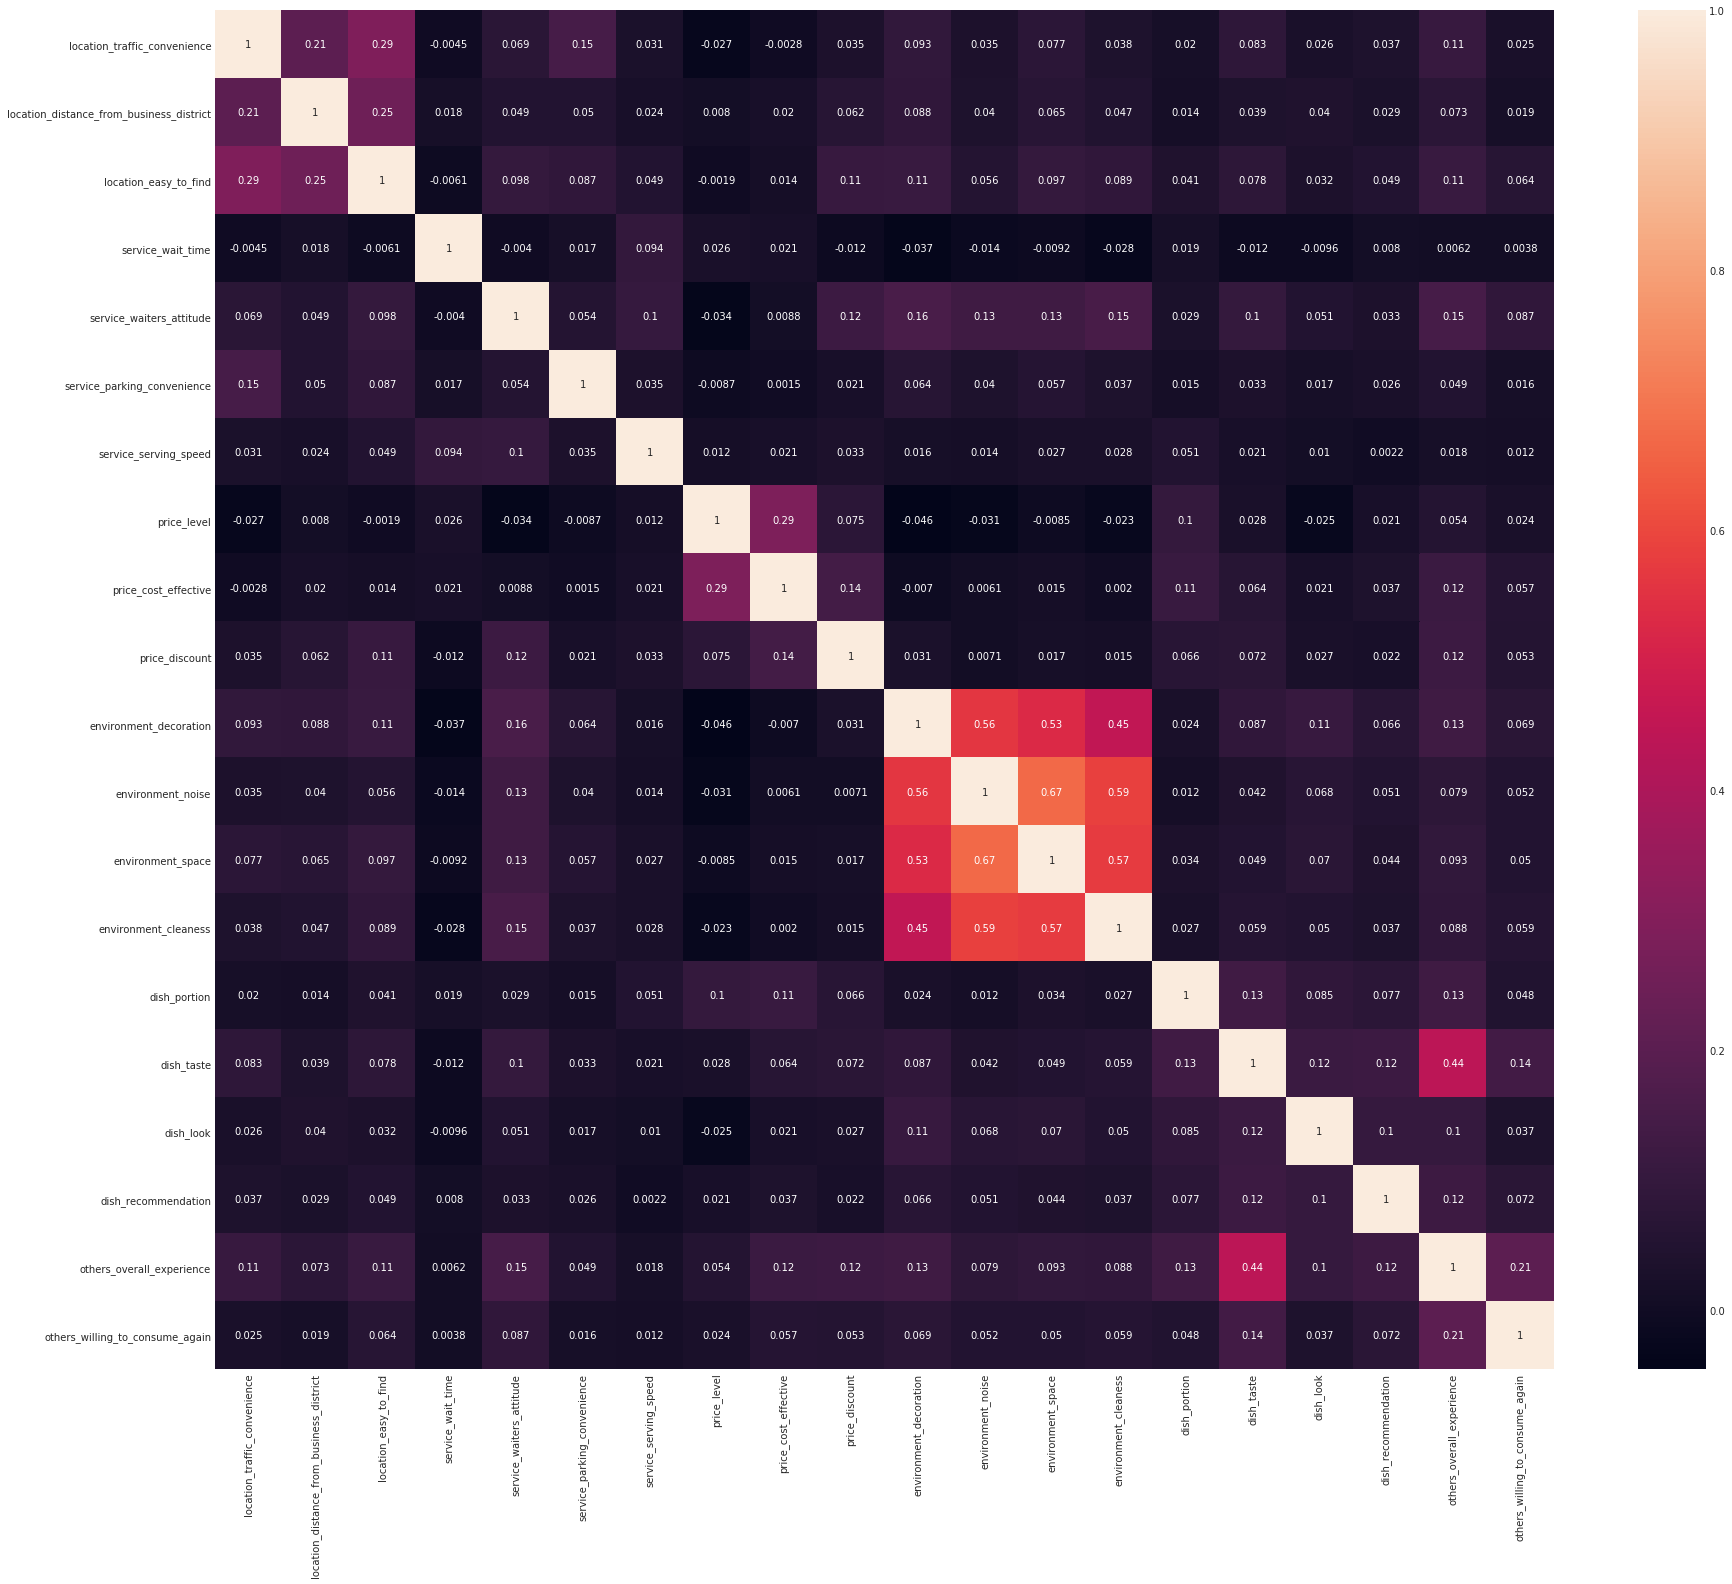

In [5]:
temp_df=train.iloc[:,1:]

corr=temp_df.corr()
plt.figure(figsize=(30,25))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

## 数据在不同各个方面不同情感之间的分布

In [6]:
classes = train.columns.tolist()[2:]

In [7]:
classes 

['location_traffic_convenience',
 'location_distance_from_business_district',
 'location_easy_to_find',
 'service_wait_time',
 'service_waiters_attitude',
 'service_parking_convenience',
 'service_serving_speed',
 'price_level',
 'price_cost_effective',
 'price_discount',
 'environment_decoration',
 'environment_noise',
 'environment_space',
 'environment_cleaness',
 'dish_portion',
 'dish_taste',
 'dish_look',
 'dish_recommendation',
 'others_overall_experience',
 'others_willing_to_consume_again']

In [11]:
def plot_dest_non_2(classes, df=train):
    fig, axs = plt.subplots(ncols=len(classes))
    for i, v in enumerate(classes):
        sns.countplot(x=v, data=df[df[v]!= -2], ax=axs[i])
    plt.tight_layout()  
    plt.show()

In [17]:
for i, v in enumerate(classes):
    print(train[v].value_counts())

-2    81382
 1    21254
-1     1318
 0     1046
Name: location_traffic_convenience, dtype: int64
-2    83680
 1    20201
-1      586
 0      533
Name: location_distance_from_business_district, dtype: int64
-2    80605
 1    17947
-1     3976
 0     2472
Name: location_easy_to_find, dtype: int64
-2    92763
 1     4821
 0     4382
-1     3034
Name: service_wait_time, dtype: int64
-2    42410
 1    41372
 0    12534
-1     8684
Name: service_waiters_attitude, dtype: int64
-2    98276
 1     3945
 0     1456
-1     1323
Name: service_parking_convenience, dtype: int64
-2    88700
 1     8434
-1     5487
 0     2379
Name: service_serving_speed, dtype: int64
-2    52820
 0    24249
 1    15556
-1    12375
Name: price_level, dtype: int64
-2    80242
 1    18675
 0     3072
-1     3011
Name: price_cost_effective, dtype: int64
-2    64243
 1    20786
 0    18255
-1     1716
Name: price_discount, dtype: int64
-2    53916
 1    39453
 0     9492
-1     2139
Name: environment_decoration, dtype: in

## 查看一下数据

In [22]:
for i, k in enumerate(classes):
    for flag, v in [('好评',1), ('中评', 0), ('差评',-1)]:
        print(f"{' '.join(k.split('_'))} 方面 {flag}句子示例:")
        print("\n".join(train[train[k]==v].iloc[:3,1].tolist()))


location traffic convenience 方面 好评句子示例:
" 很棒 的 一次 自助 体验 ～ 之前 就团 好 的 券 一直 延期 就 一直 推 今天 才 来 吃 了 ～ 【 地址 】 在 火车站 附近 十字路口 在 修 地铁 所以 有 一些 不太好 过 马路 很 迷茫 哈哈哈 哈哈哈 不过 很 显眼 的 太阳宫 ～ 【 环境 】 在 酒店 进去 以后 下负 一层 很棒 的 环境 ！ 超级 高大 上 ～ 里面 也 特别 大 ～ 拿 东西 也 是 很 方便 的 ～ 【 服务 】 先验 券 定 桌子 然后 拿 筷子 进去 之后 找到 自己 的 桌子 就 可以 开始 啦 ～ 因为 我们 是 周内 中午 去 的 所以 人 不是 很多 感觉 还 不错 ～ 【 口味 】 种类 真的 超级 多 ， 什么 都 有 ， 海鲜 ， 三文鱼 ， 扇贝 ， 铁板 鱿鱼 ， 寿司 ， 蛋糕 ， 点心 ， 沙拉 ， 烧烤 ， 火锅 。 不过 其实 吃 不了 多少 因为 种类 太多 啦 ～ 哈哈哈哈 然后 海鲜 和 三文鱼 都 不是 自取 的 是 问 厨师 要 的 不过 也 是 很 好 的 啦 ～ 【 体会 】 之前 团 的 还是 很 超值 的 ～ 满意 ～ "
" 很 感谢 大众 点评 网 和 店家 举办 的 这次 试吃 活动 结识 了 很多 新 朋友 很 开心 菜品 味道 很 好 个人 比较 喜欢 辣 炒 蛏子 蛏子 味道 很 鲜美 辣味 适中 不错 熏 排骨 特 实惠 排骨 都 是 超 大块 的 而且 肉 很多 很 好吃 蒜蓉 蒸 扇贝 也 很棒 扇贝 肉 很大 很 美味 清蒸 多宝 肉质 很 细腻 本人 喜欢 盐水 虾 是 最 爱 虾 很大 只 很 入味 孜然 大 泥鳅 这个 是 特色菜 第一次 吃 味道 很想 烤鱼 有 亮点 还有 大爱 的 炉 肉包 超大 一个 馅料 很满 味道 很 好 开始 第一口 就 爱 上 了 三味 鸡卷 也 很 好吃 很 特色 三鲜 嘎达 汤料 很足 干锅 菜花 做 的 很 不错 还有 二哥 煮 杂鱼 虾酱 卷子 很 农家 总体 很棒 店家 给 的 量 很大 很 实惠 吃 得 舒服 开心 他家 店门口 就是 公交站 有 953 路 9 路 交通 方便 "
" 假期 外地 朋友 来 青岛 ， 带 着 他们 吃 地道 海鲜 ， 下 了 火车 真